### Required libraries

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sys
import numpy as np
import os.path as op


### Utils

In [115]:
def plot_hist(score,title,xlabel):
    h,b = np.histogram(score, bins='auto')
    plt.hist(score,bins=b)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    return h

### Parameters

In [120]:
behavFile = 'unrestricted_luckydjuju_11_17_2015_0_47_11.csv'
release = 'Q2'
outScore = 'PMAT24_A_CR'
DATADIR = '/mnt/HCP/'
parcellation = 'shenatal_neuroimage2013'
thisRun = 'rfMRI_REST1'

if thisRun == 'rfMRI_REST1':
    outMat = 'rest_1_mat'
elif thisRun == 'rfMRI_REST2':
    outMat = 'rest_1_mat'
else:
    sys.exit("Invalid run code")    

### Get subjects

In [113]:
df = pd.read_csv(behavFile)

# select subjects according to release
if release == 'Q2':
    ind = (df['Release'] == 'Q2') \
    | (df['Release'] == 'Q1')
elif release == 'S500':
    ind = (df['Release'] != 'Q2') & (df['Release'] != 'Q1')
else:
    sys.exit("Invalid release code")
    
# select subjects that have completed all fMRI
ind = ind & ((df['fMRI_WM_Compl']== True) & (df['fMRI_Mot_Compl']==True) \
        & (df['fMRI_Lang_Compl']==True) & (df['fMRI_Emo_Compl']==True) \
        & (df['RS-fMRI_Count']==4))
                
df = df[ind]  

# check if either of the two subjects recommended for exclusion by HCP are still present
df = df[~df['Subject'].isin(['209733','528446'])]
df.index = range(df.shape[0])
print 'Selected', str(df.shape[0]), 'from the release',release
print 'Number of males is:', df[df['Gender']=='M'].shape[0]
tmpAgeRanges = sorted(df['Age'].unique())
print 'Age range is', tmpAgeRanges[0].split('-')[0], '-', tmpAgeRanges[-1].split('-')[1]

# list of all selected subjects
subjects = df['Subject']
# pull their IQ, Age, Gender
age = df['Age']
gender = df['Gender']
score = df[outScore]

Selected 125 from the release Q2
Number of males is: 40
Age range is 22 - 35


### Score distribution

array([ 3,  7, 10, 10, 15, 17, 19, 27, 17])

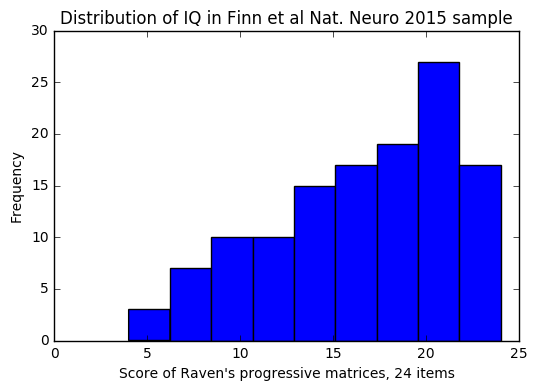

In [117]:
plot_hist(score, 'Distribution of IQ in Finn et al Nat. Neuro 2015 sample', \
          'Score of Raven\'s progressive matrices, 24 items')

### Exclusion of high-motion subjects
Further exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)

In [134]:
PEdirs = ['LR', 'RL']
RelRMSMean = np.zeros([len(subjects), 2])
for iSub in range(len(subjects)):
    RelRMSMeanFile = op.join(DATADIR, str(subjects[iSub]), 'MNINonLinear','Results', \
                                 thisRun+'_zz', 'Movement_RelativeRMS_mean.txt')
    fLR = RelRMSMeanFile.replace('zz','LR');
    fRL = RelRMSMeanFile.replace('zz','RL');
    if op.isfile(fLR) & op.isfile(fRL):
        with open(fLR,'r') as tmp:
            RelRMSMean[iSub,0] = float(tmp.read())
        with open(fRL,'r') as tmp:
            RelRMSMean[iSub,1] = float(tmp.read())
        print '{} {:.3f} {:.3f}'.format(subjects[iSub], RelRMSMean[iSub,0], RelRMSMean[iSub,1])    

100307 0.062 0.076
103414 0.069 0.080
103515 0.118 0.113
103818 0.104 0.092
105115 0.065 0.065
110411 0.069 0.057
111312 0.085 0.076
113619 0.076 0.066
114924 0.184 0.112
115320 0.103 0.107
117122 0.102 0.084
118730 0.088 0.091
118932 0.088 0.088
119833 0.122 0.109
120212 0.100 0.104
123117 0.163 0.156
124422 0.064 0.064
125525 0.084 0.116
128632 0.063 0.064
129028 0.075 0.080
130013 0.073 0.068
133827 0.109 0.132
133928 0.070 0.070
134324 0.083 0.065
135932 0.060 0.066
136833 0.099 0.091
137128 0.084 0.080
138231 0.093 0.077
139637 0.068 0.068
142828 0.085 0.083
143325 0.115 0.107
149337 0.046 0.056
149539 0.088 0.087
150423 0.048 0.052
151223 0.196 0.132
151627 0.058 0.068
153429 0.082 0.101
156637 0.141 0.156
157336 0.071 0.079
158035 0.063 0.074
158540 0.144 0.125
159239 0.084 0.076
161731 0.109 0.117
162329 0.128 0.089
163432 0.088 0.074
167743 0.107 0.099
169343 0.084 0.086
172332 0.085 0.098
175439 0.148 0.115
182739 0.091 0.090
185139 0.087 0.081
191437 0.189 0.166
192439 0.101